In [3]:
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy import ndimage
def crop_cell(img_path):
    # Load the uploaded image
    img = cv2.imread(img_path)
    
    #########################
    ##### Preprocessing #####
    #########################
    ############## Rotate the image to correct the orientation ################
    ###### APPLY FILTER ON THE IMAGE TO ERASE THE TEXT AND NOISE
    ## Convert image to grayscale image 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ## Apply Gaussian Blur for smoothing
    gray = cv2.GaussianBlur(gray, (11, 11), 8) 
    ## Increase the brightness by 50
    gray = cv2.convertScaleAbs(gray, alpha=1, beta=50)
    ## Apply CLAHE to enhance constrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    ###### DETECT EDGES AND LINES TO DEFINE DOMINANT ORIENTATION
    edges = cv2.Canny(gray, 155, 200, apertureSize=3)
    # Use Hough Line Transformation to detect lines in the image
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    # Calculate the angles of the detected lines
    angles = []
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            angle = np.degrees(theta)
            if 80 < angle < 100:  # We filter out near-vertical lines to find the dominant orientation
                angles.append(angle - 90)  # Subtract 90 to normalize angle close to zero
    # Compute the average angle of the lines
    if len(angles) > 0:
        avg_angle = np.mean(angles)
    else:
        avg_angle = 0  # No rotation needed if no dominant angle found
    # Rotate the image to correct the orientation
    (h, w) = gray.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, avg_angle, 1.0)
    rotated_image_raw = cv2.warpAffine(img, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img)
    ax[0].set_title("Raw Image")
    ax[0].axis('off')
    ax[1].imshow(rotated_image_raw)
    ax[1].set_title("Rotated Image")
    ax[1].axis('off')
    
    ######### PREPROCESS THE ROTATED IMAGE TO DETECT CELL ###########
    ## Convert image to grayscale image 
    gray = cv2.cvtColor(rotated_image_raw, cv2.COLOR_BGR2GRAY)
    ## Apply Gaussian Blur for smoothing
    gray = cv2.GaussianBlur(gray, (11, 11), 8) 
    ## Increase the brightness by 50
    gray = cv2.convertScaleAbs(gray, alpha=1, beta=50)
    ## Apply CLAHE to enhance constrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    rotated_image = clahe.apply(gray)
    
    ##############################
    ####### Mainprocessing #######
    ##############################
    ############## HIGHLIGHT THE VERTICAL AND HORIZONTAL LINES ################
    grad_x = cv2.Sobel(rotated_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(rotated_image, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    grad_dir = np.arctan2(grad_y, grad_x) * 180 / np.pi
    # Convert gradients to absolute values and scale to 8-bit
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    # Threshold the gradients to keep only strong horizontal and vertical lines
    _, binary_x = cv2.threshold(abs_grad_x, 100, 255, cv2.THRESH_BINARY)
    _, binary_y = cv2.threshold(abs_grad_y, 100, 255, cv2.THRESH_BINARY)
    # Combine the binary images to get both horizontal and vertical lines
    combined = cv2.bitwise_or(binary_x, binary_y)
    # Apply morphological operations to clean up the result
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    cleaned = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)
    edges = cv2.Canny(rotated_image * cleaned, 50, 200, apertureSize=3)
    
    # Show images
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(cleaned)
    ax[0].set_title("Cleaned Image")
    ax[0].axis('off')
    ax[1].imshow(edges)
    ax[1].set_title("Edge detection")
    ax[1].axis('off')
    
    ##############################
    ####### Postprocessing #######
    ##############################
    ############ DETECT CONTOURS AND FILTER OUT NOISE ############
    # Detect contours on the morphed/dilated image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Filter the contours based on size (ignoring small ones, which are likely noise)
    filtered_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Filter by size: assuming cells are large enough, we skip small areas
        if w > 300 and h > 40 and h < 70 and w < 500:
            filtered_contours.append(contour)
    # Sort contours from top-to-bottom, left-to-right
    def sort_contours(cnts):
        bounding_boxes = [cv2.boundingRect(c) for c in cnts]
        # Sort by row first (y), then by column (x)
        (cnts, bounding_boxes) = zip(*sorted(zip(cnts, bounding_boxes), key=lambda b: (b[1][1], b[1][0])))
        return cnts
    sorted_contours = sort_contours(filtered_contours)
    
    print(f"Number of cells : {len(sorted_contours)}")
    fig, ax = plt.subplots(math.ceil(len(sorted_contours) / 4), 4, figsize=(12, 6))
    for a in ax.ravel():
        a.axis('off')
    print(ax.shape)
    # Draw the rectangles around the cells and save them
    for i, contour in enumerate(sorted_contours):
        x, y, w, h = cv2.boundingRect(contour)
        cell = rotated_image_raw[y:y+h, x:x+w]
        # Save each cell imAage
        # cv2.imwrite(f'out/cell_{i}.png', cell)
        ax[i//4][i%4].imshow(cell)

Number of cells : 92
(23, 4)


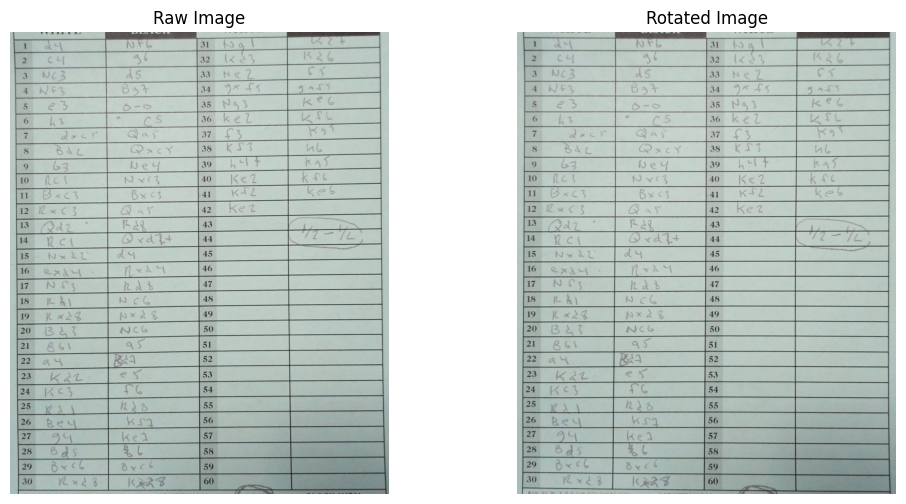

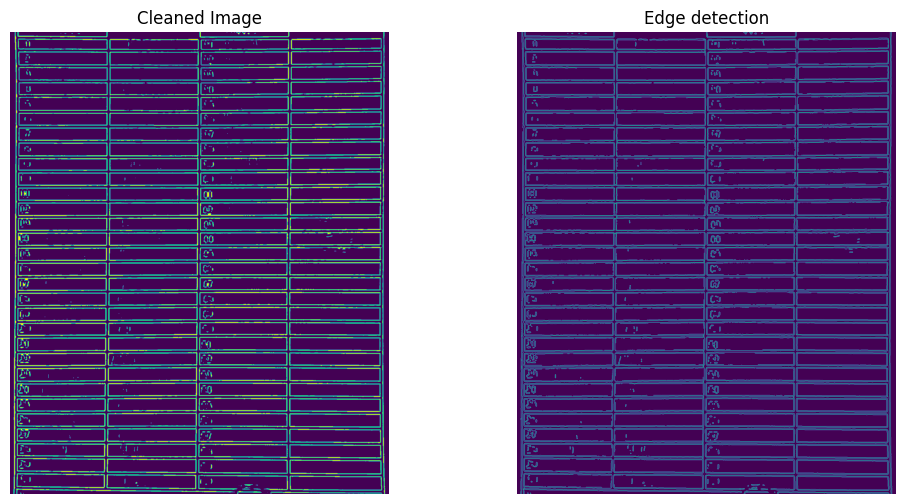

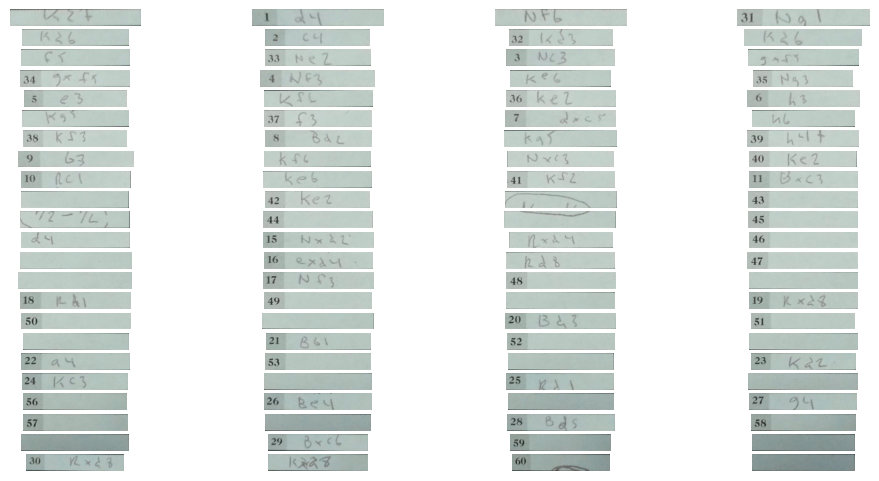

In [4]:
crop_cell("/home/rhev/Works/Code/CV-basic/data/prj1-4/009_0.png")

Number of cells : 86
(22, 4)


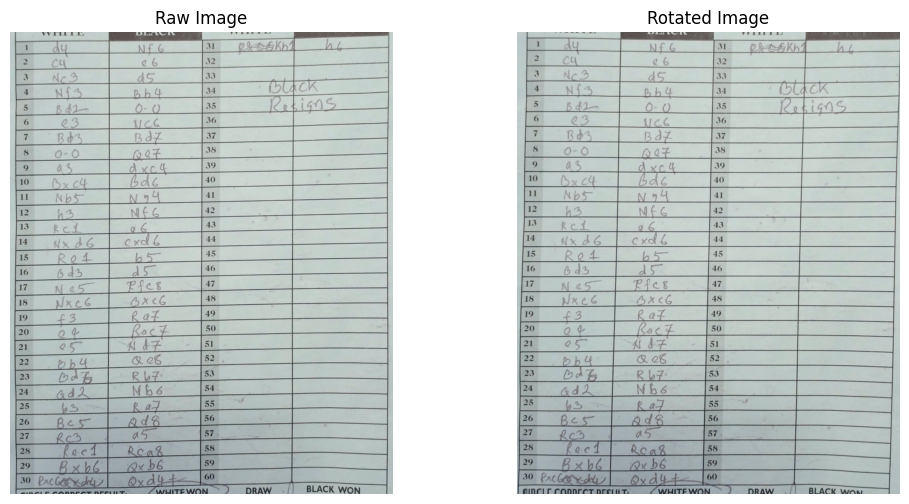

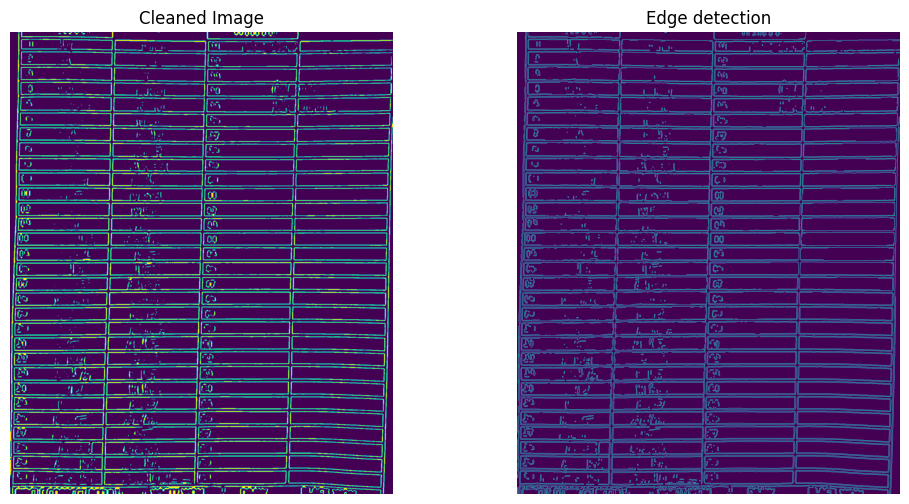

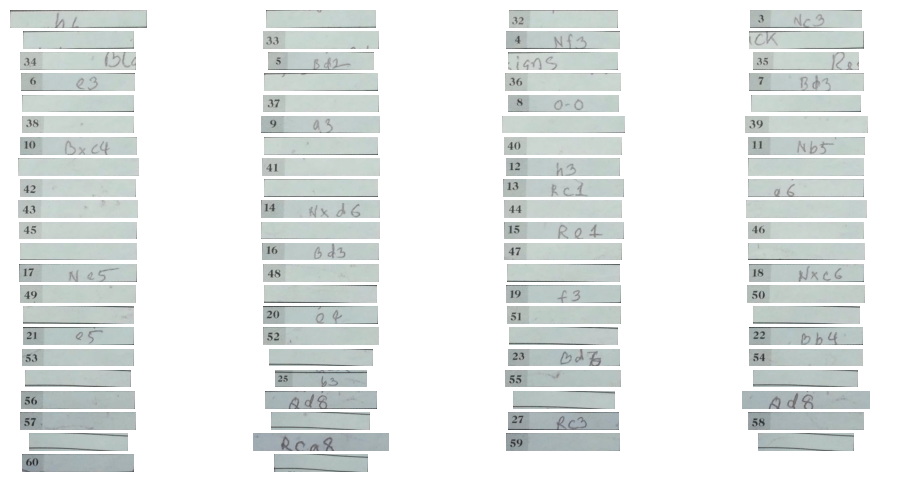

In [5]:
crop_cell("/home/rhev/Works/Code/CV-basic/data/prj1-4/001_0.png")

Number of cells : 6
(2, 4)


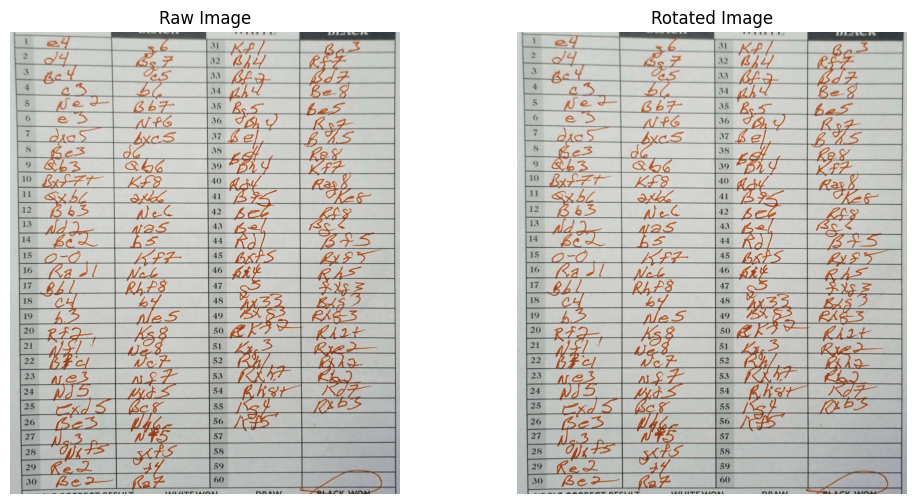

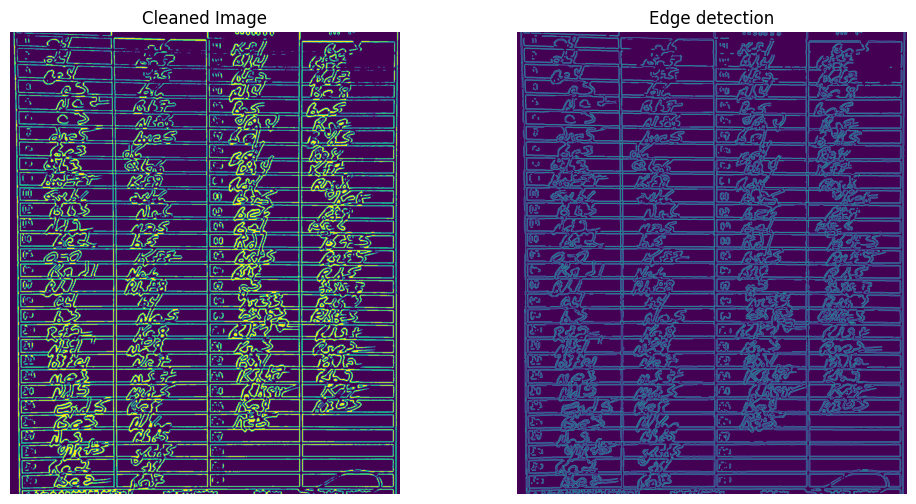

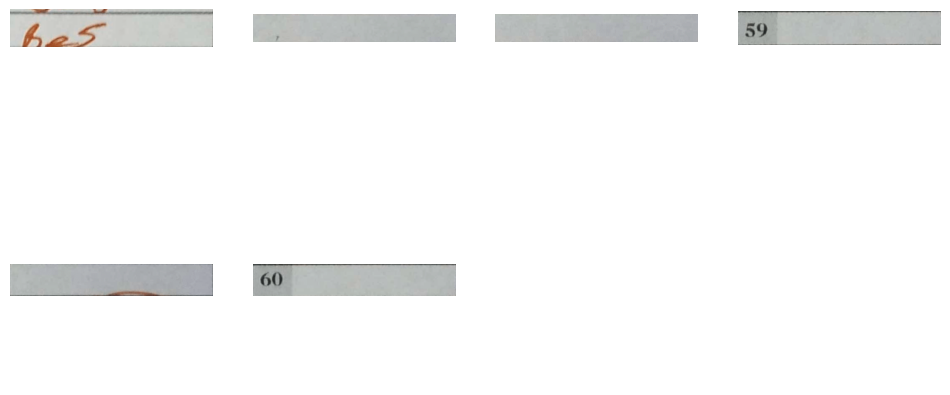

In [6]:
crop_cell("/home/rhev/Works/Code/CV-basic/data/prj1-4/011_0.png")

Number of cells : 70
(18, 4)


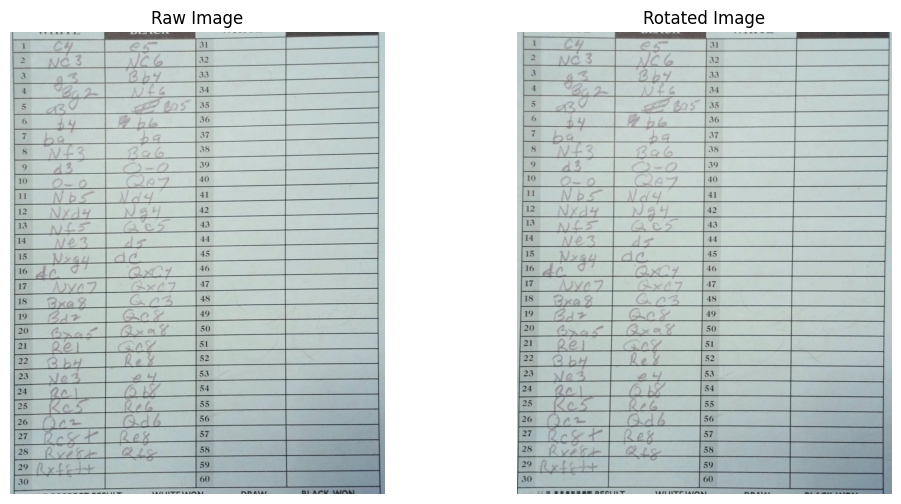

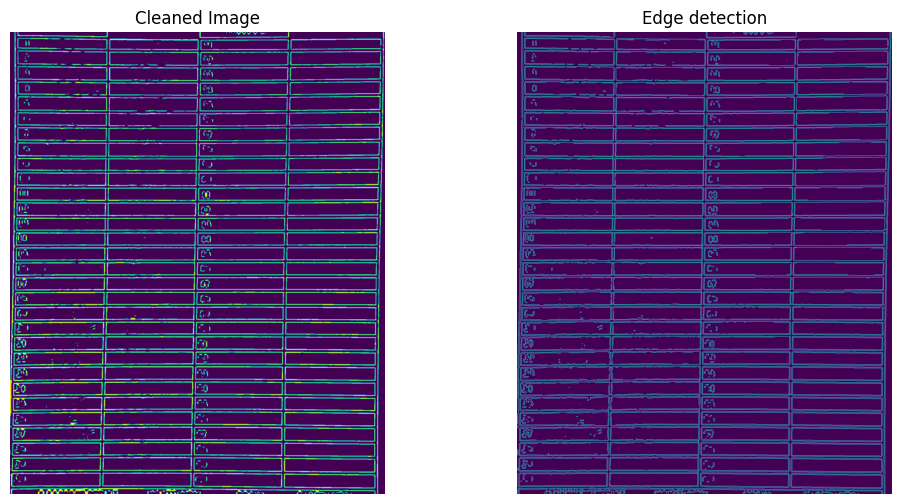

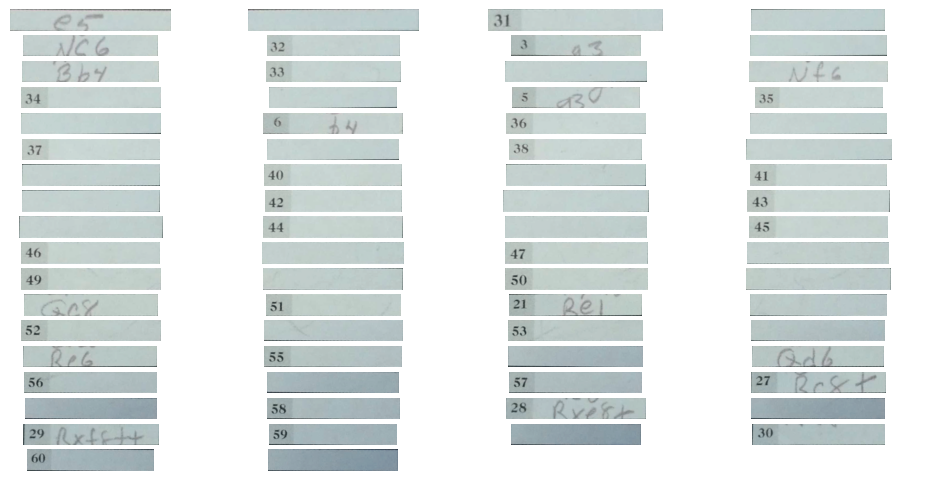

In [7]:
crop_cell("/home/rhev/Works/Code/CV-basic/data/prj1-4/012_0.png")
